# Nixtla Python Packages for Forecasting

## MLForecast

### MLForecast Intro

MLForecast does feature engineering and takes care of the updates for you, the user only has to provide a regressor that follows the scikit-learn API (implements fit and predict) and specify the features that she wants to use. These features can be lags, lag-based transformations, and date features.

For many years clasical methods like ARIMA or ETS dominated the forecasting field. One of the reasons was that most of the use cases involved forecasting low-frequency serises with monthly, quarterly, or yearly granuarity. Futhermore, there weren't many time-series datasets, so fitting a single model to each one and getting forecasts from them was straightforward. However, in recent years, the need to forecast bigger datasets higher frequencies has risen. To address this problem, there have been efforts in proposing different methods that can train a single model on many time series. Some deep learning architectures are ESRNN, DeepAR, NBeats, NHits. **Also traditional machine learning models like gradient boosting trees have been used as well, and have shown that they can achieve very good performance as well.**

<AxesSubplot: xlabel='ds'>

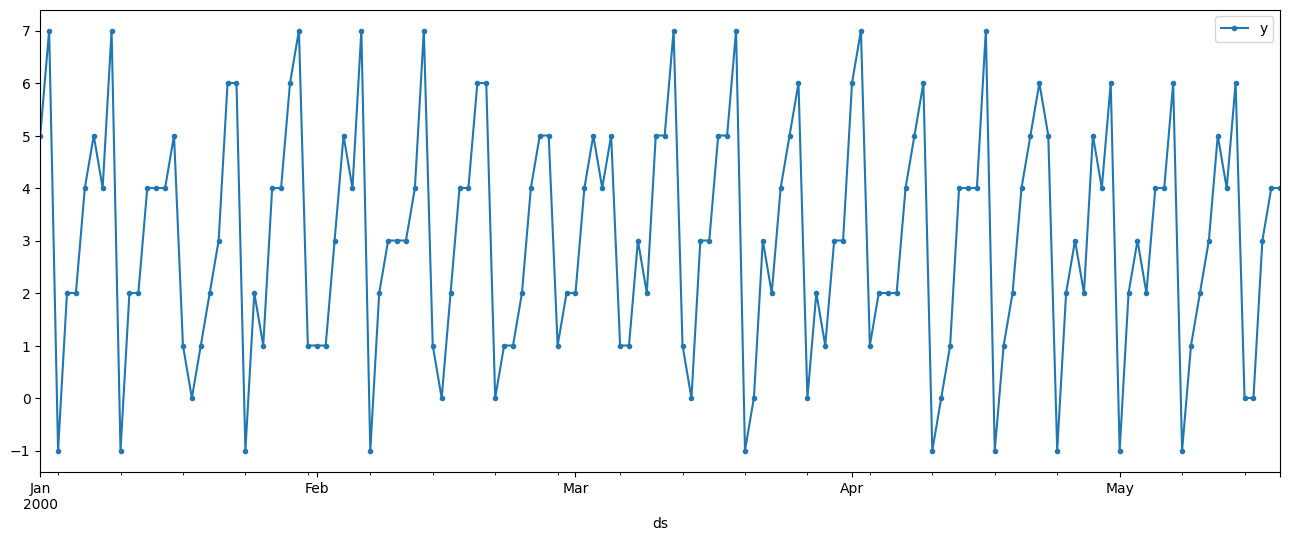

In [1]:
# EXAMPLE:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

# Data:
rng = np.random.RandomState(90)
serie_length = 7 * 20
dates = pd.date_range('2000-01-01', freq='D', periods=serie_length, name='ds')
y = dates.dayofweek + rng.randint(-1, 2, size=dates.size)
data = pd.DataFrame({'y': y.astype(np.float64)}, index=dates)
data.plot(marker='.', figsize=(16, 6))

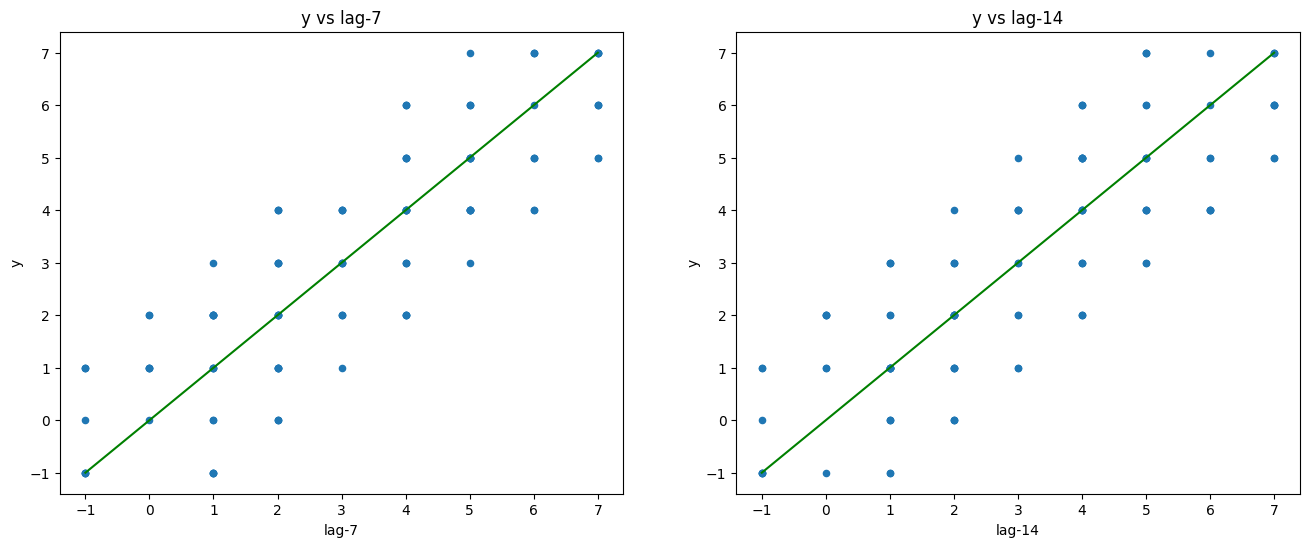

In [2]:
# TRAINING 

valid_horizon = 14
train = data.head(-valid_horizon).copy()
y_valid = data.tail(valid_horizon)['y']

## As a starting point, we’ll try lag 7 and lag 14.

train['lag-7'] = train['y'].shift(7)
train['lag-14'] = train['y'].shift(14)

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

for lag, axi in zip((7, 14), ax.flat):
    train.plot.scatter(x=f'lag-{lag}', y='y', ax=axi)
    axi.plot([-1, 7], [-1, 7], c='g')
    axi.set_title(f'y vs lag-{lag}')

In [3]:
train.isnull().sum()

y          0
lag-7      7
lag-14    14
dtype: int64

In [4]:
## We’ll drop these before training.

train_without_nulls = train.dropna()
X_train = train_without_nulls.drop(columns='y')
y_train = train_without_nulls['y']

In [5]:
# For simplicity sake, we’ll train a linear regression without intercept. 
# Since the best model would be taking the average for each day of the week, we expect to get coefficients that are close to 0.5.

lr = LinearRegression(fit_intercept=False).fit(X_train, y_train)
lr.coef_

array([0.5136953 , 0.44695162])

#### Forecasting

Great. We have our trained model. How can we compute the forecast for the next 14 days? Machine learning models a feature matrix X and output the predicted values y. So we need to create the feature matrix X for the next 14 days and give it to our model.

If we want to get the lag-7 for the next day, following the training set, we can just get the value in the 7th position starting from the end. The lag-7 two days after the end of the training set would be the value in the 6th position starting from the end and so on. Similarly for the lag-14.

In [6]:
next_lags_7 = y_train.tail(7).values
next_lags_7

array([ 4.,  6., -1.,  2.,  3.,  2.,  4.])

In [7]:
next_lags_14 = y_train.tail(14).values
next_lags_14

array([ 6.,  5., -1.,  2.,  3.,  2.,  5.,  4.,  6., -1.,  2.,  3.,  2.,
        4.])

In [8]:
X_valid1 = pd.DataFrame({
    'lag-7': next_lags_7,
    'lag-14': next_lags_14[:7],
})
X_valid1

,lag-7,lag-14
0,4.0,6.0
1,6.0,5.0
2,-1.0,-1.0
3,2.0,2.0
4,3.0,3.0
5,2.0,2.0
6,4.0,5.0


In [9]:
forecasts_7 = lr.predict(X_valid1)
forecasts_7

array([ 4.7364909 ,  5.31692988, -0.96064692,  1.92129383,  2.88194075,
        1.92129383,  4.28953928])

In [10]:
X_valid2 = pd.DataFrame({
    'lag-7': forecasts_7,
    'lag-14': next_lags_14[-7:],
})
X_valid2

,lag-7,lag-14
0,4.736491,4.0
1,5.316930,6.0
2,-0.960647,-1.0
3,1.921294,2.0
4,2.881941,3.0
5,1.921294,2.0
6,4.289539,4.0


In [11]:
forecasts_7_14 = lr.predict(X_valid2)
y_pred = np.hstack([forecasts_7, forecasts_7_14])
y_pred

array([ 4.7364909 ,  5.31692988, -0.96064692,  1.92129383,  2.88194075,
        1.92129383,  4.28953928,  4.22091958,  5.41299159, -0.94043142,
        1.88086285,  2.82129427,  1.88086285,  3.99132264])

What if we had used lag-1? We would have needed to do this predict-update step 14 times!

And what if we had more elaborate features like the rolling mean over some lag? As you can imagine it can get quite messy and is very error prone.

**mlforecast**

With these problems in mind, we created mlforecast, which is a framework to help you forecast time series using machine learning models. It takes care of all these messy details for you. You just need to give it a model and define which features you want to use and let mlforecast do the rest.

In [44]:
train_mlfcst = train.reset_index()[['ds', 'y']]
train_mlfcst.index = pd.Index(np.repeat(0, train.shape[0]), name='unique_id')
train_mlfcst.head()

,ds,y
unique_id,,
0,2000-01-01,5.0
0,2000-01-02,7.0
0,2000-01-03,-1.0
0,2000-01-04,2.0
0,2000-01-05,2.0


This is the required input format.

- an index named unique_id that identifies each time serie. In this case we only have one but you can have as many as you want.
- a ds column with the dates.
- a y column with the values.

Now we’ll import the **TimeSeries** transformer, where we define the features that we want to use. We’ll also import the **Forecast** class, which will hold our transformer and model and will run the forecasting pipeline for us.

In [42]:
# As you can see this transformer will use lag-7 and lag-14 as features. Now we define our model.

model = LinearRegression(fit_intercept=False)

In [45]:
# We create a Forecast object with the model and the time series transformer and fit it to our data.

from mlforecast import MLForecast

fcst = MLForecast(
    models=[model],
    freq='D',
    lags=[7, 14]
)

In [46]:
fcst.fit(train_mlfcst, id_col='index', time_col='ds', target_col='y')

MLForecast(models=[LinearRegression], freq=<Day>, lag_features=['lag-7', 'lag-14'], date_features=[], num_threads=1)

In [47]:
y_pred_mlfcst = fcst.predict(14)
y_pred_mlfcst

,ds,LinearRegression
unique_id,,
0,2000-05-06,4.736491
0,2000-05-07,5.316930
0,2000-05-08,-0.960647
0,2000-05-09,1.921294
0,2000-05-10,2.881941
0,2000-05-11,1.921294
0,2000-05-12,4.289539
0,2000-05-13,4.220920
0,2000-05-14,5.412992


### ML Forecasting - Multiple Time Series Forecasting

We will use real sales data made available by Favorita, a large Ecuadorian grocery chain.

We have sales data from 2013 to 2017 for multiple stores and product categories.

To run this example faster, we will only use the data from one store and two product categories.

So we have 2 time series to forecast, but this code can be used with as many time series as you want.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path='data'
data=pd.read_csv(f'data/train.csv',index_col='id',parse_dates=['date'])

In [2]:
data2 = data.loc[(data['store_nbr'] == 1)&\
                 (data['family'].isin(['MEATS','PERSONAL CARE'])),['date', 'family', 'sales', 'onpromotion']]

This data doesn’t contain a record for December 25, so I just copied the sales from December 18 to December 25 to keep the weekly pattern.


To keep Nixtla’s (the creator of mlforecast) libraries standard format, let’s rename the columns to ds (date), y (target) and unique_id (family).

unique_id should identify each time series you have.

If we had more than one store, we would have to add the store number along with the categories to unique_id.

An example would be unique_id = store_nbr + '_' + family.

In [3]:
dec25 = list()
for year in range(2013,2017):
    for family in ['MEATS', 'PERSONAL CARE']:
        dec18 = data2.loc[(data2['date'] == f'{year}-12-18') & (data2['family'] == family)]
        dec25 += [{'date': pd.Timestamp(f'{year}-12-25'), 'family': family, 'sales': dec18['sales'].values[0], 'onpromotion': dec18['onpromotion'].values[0]}]
data2 = pd.concat([data2, pd.DataFrame(dec25)], ignore_index=True).sort_values('date')

data2 = data2.rename(columns={'date': 'ds', 'sales': 'y', 'family': 'unique_id'})

In [4]:
data2

,ds,unique_id,y,onpromotion
0,2013-01-01,MEATS,0.000,0
1,2013-01-01,PERSONAL CARE,0.000,0
2,2013-01-02,MEATS,369.101,0
3,2013-01-02,PERSONAL CARE,194.000,0
4,2013-01-03,MEATS,272.319,0
...,...,...,...,...
3363,2017-08-13,PERSONAL CARE,45.000,5
3364,2017-08-14,MEATS,192.763,0
3365,2017-08-14,PERSONAL CARE,159.000,9
3366,2017-08-15,MEATS,274.176,0


#### Time Series Validation

In practice, you can’t take random samples from the future to train your model, so you can’t use them here.

To avoid this issue, we will use a simple time series split between past and future.

A career tip: knowing how to do time series validation correctly is a skill that will set you apart from many data scientists (even experienced ones!).

Our training set will be all the data between 2013 and 2016 and our validation set will be the first 3 months of 2017.

In [5]:
train = data2.loc[data2['ds'] < '2017-01-01']
valid = data2.loc[(data2['ds'] >= '2017-01-01') & (data2['ds'] < '2017-04-01')]

#### Feature Engineering for Time Series Forecasting

Now that we have our data formatted according to what mlforecast expects, let’s define the features we are going to use.

This is a crucial step for the success of your model.

I usually think of 4 main types of features for time series. You can calculate them using the target or external variables:

#### Lags

Lags are simply past values of the time series that you shift forward to use as features in the model. For example, if you want to predict the demand of a product next week, you can use the demand of the same weekday in the previous week as a feature.

In practice, the demand of a product on a given day of the week is similar in different weeks, so this feature can be useful for the model. You can also use longer lags, like the demand of the same day in the previous month or year.

It’s important to test different lags to find the ones that work best for your specific problem.

Don’t be afraid of adding lots of lag features!

No one can tell you which lags are the best for your problem without testing.


#### Rolling Window Aggregations

Rolling window aggregations are statistical functions applied to records in a sliding window. They can be calculated over expanding windows too, but sliding windows are usually more robust in practice. An example is calculating the average daily demand of the last 7 days, or the standard deviation of the returns of a financial asset over the last 4 weeks.

These features can help the model identify trends in the time series. Like lags, it’s important to test different aggregation functions and window sizes to find the ones that work best for your specific problem.


#### Date Components

Date components are values you extract from a specific date or timestamp. For example, you can include the hour of the day, the day of the week, the month, the season of the year, etc.

These features can help the model identify seasonal and cyclical patterns in the time series. As with other features, test different components and find the ones that work best.


#### Differences

Differences are simply the subtraction of two values in a time series. An example is the difference between the demand of today and the demand of yesterday.

Even though we have lags, having differences as features can bring specific information the model needs to more easily identify patterns.

Feature engineering is a lot about making the patterns in the data more explicit for the model.

#### Feature Engineering Code

Now that we know the features we want to use, let’s compute them with the **mlforecast library.** First, we need to create a list with the scikit-learn models we want to test.

In [6]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

models = [RandomForestRegressor(random_state=0, n_estimators=100),
          ExtraTreesRegressor(random_state=0, n_estimators=100)]

I will test only 2 models, the Random Forest and the Extra Trees, but you can test as many models as you want. Just add them to the list.

At the time of writing, **mlforecast** and **window_ops** don’t support calculating difference features, so I created the diff function using **numba**.

In [7]:
from numba import njit

@njit
def diff(x,lag):
    x2=np.full_like(x,np.nan)
    for i in range(lag,len(x)):
        x2[i]=x[i]-x[i-lag]
    return x2

**numba** is a library that optimizes your Python code to run faster and it’s recommended by the mlforecast developers when creating custom functions to compute features. We need to add the @njit decorator to the function to tell **numba** to compile it.

The function gets two arguments, x and lag. x is an array and lag is the number of periods we want to use to calculate the difference.

The first line inside the function creates a new array x2 with the same format as the array x, but all the values are initialized as NaN. Inside the loop, we will set the values of x2 to the difference between the values in x and the values in x shifted by lag periods.
If it’s a lag of 3, for example, the value in position 3 of x2 is the difference between the value in position 3 and the value in position 0 of x.

The function returns the array x2 with the differences for each period. Now we will create the object that manages the creation of the features and the training of the models.

[WINDOW_OPS](https://github.com/jmoralez/window_ops/blob/main/nbs/rolling.ipynb)

In [11]:
from typing import Callable, Optional
from window_ops.utils import _gt, _lt, _validate_rolling_sizes, first_not_na

def rolling_docstring(*args, **kwargs) -> Callable:
    base_docstring = """
        Compute the {} over the last non-na window_size samples of the
        input array starting at min_samples.
    """

    def docstring_decorator(function: Callable):
        function.__doc__ = base_docstring.format(function.__name__)
        return function
        
    return docstring_decorator(*args, **kwargs)

@njit
@rolling_docstring
def rolling_mean(input_array: np.ndarray,
                 window_size: int,
                 min_samples: Optional[int] = None) -> np.ndarray:
    n_samples = input_array.size
    window_size, min_samples = _validate_rolling_sizes(window_size, min_samples)
    
    output_array = np.full_like(input_array, np.nan)
    start_idx = first_not_na(input_array)
    if start_idx + min_samples > n_samples:
        return output_array
    
    accum = 0.
    upper_limit = min(start_idx + window_size, n_samples)
    for i in range(start_idx, upper_limit):
        accum += input_array[i]
        if i + 1 >= start_idx + min_samples:
            output_array[i] = accum / (i - start_idx + 1)
            
    for i in range(start_idx + window_size, n_samples):
        accum += input_array[i] - input_array[i - window_size]
        output_array[i] = accum / window_size

    return output_array

In [14]:
from mlforecast import MLForecast

model = MLForecast(models=models,
                   freq='D',
                   lags=[1,7,14],
                   lag_transforms={
                       1: [(rolling_mean, 3), (rolling_mean, 7), (rolling_mean, 28), (diff, 1), (diff, 7)],
                   },
                   date_features=['dayofweek'],
                   num_threads=-1)

/home/bruno/MachineLearning_Training/TimeSeries_Learning/time_series_analysis/lib/python3.8/site-packages/mlforecast/core.py:280: UserWarning: Setting num_threads to 1.
  warnings.warn("Setting num_threads to 1.")


**MLForecast** is the object that will make our work easier. It manages feature engineering and model training.

The first argument, models, is the list with the models we want to train. The second is freq, which indicates the frequency of the time series. Daily in our example The third argument, lags=[1,7,14], indicates the lag values we want to use as features. We will use lags of 1, 7 and 14 days. The fourth argument, lag_transforms={...}, is a dictionary with the functions we want to apply to the lags:
- The keys in the dictionary are the lag series to which the functions will be applied.
- We will calculate a rolling mean of lag 1 with windows of 3, 7 and 28 days, and the difference between the current value and the value 1 and 7 days before. 
- Just remember that “current value” is the series value at the lag, not the value of the current time step, as the latter is the value we want to predict. In our example, the 7-day rolling mean is computed using lag 1 as the most recent value, and so on.

The functions will get an array with the original time series shifted by the lag value in the same order as the original dataframe. Usually it’s from the oldest record to the newest. Then we set date_features=['dayofweek'] to specify which date components we want to extract. I used only the day of the week. Finally, we set num_threads=-1 to specify how many threads should be used to process the data in parallel (in my case is -1 because I want to use all available cores). 

Remember that we still have the onpromotion feature, which is an external variable related to the target. Any columns besides the target, the ID and the date will be considered as external variables. By default it considers them as static features, which means they don’t change over time (like a product brand or the store city).

During prediction it generates a dataframe with the same values for all the time steps.

We can explicitly tell which columns are static features with the static_features argument in the fit method.

Even if you don’t have any static features but have dynamic features, it’s important to pass an empty list to this argument, because MLForecast will think your dynamic features are static and ignore its new values if you don’t do that.

In [40]:
model.fit(train, id_col='unique_id', time_col='ds', target_col='y', static_features=[])

p = model.predict(horizon=90, dynamic_dfs=[valid[['unique_id', 'ds', 'onpromotion']]])
p = p.merge(valid[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')

In our case, we know which products will be on promotion in the next 90 days (we can plan it), so we can pass a dataframe with the onpromotion column for the next 90 days.

We could even use this model to simulate the impact of a promotion on sales by setting the onpromotion column to 1 for arbitrary periods in the future.

But if we had external variables that we don’t know in advance (like temperature), we would need to use estimates. **A very common mistake is to use historical values of the external variables during validation without considering that they won’t be available at the time of prediction in production.**

This shows you an overly optimistic estimate of the model performance, which won’t be real in practice. That’s why it’s important to create these features here using the same process that will be used in production.

It’s important that the dataframes with the external variables have columns that can be used to merge it with the main dataframe. At a minimum the date of the record and potentially any others that ID the time series. Thinking about temperature again, we could have the city code as a static feature, and an external variables dataframe with the city code, date and temperature estimates for the prediction period.

The last line merges the predictions with the validation dataframe to make it easier to calculate the error and visualize the results.

The predictions for each model are stored in a column with the name of the model object.

In [16]:
p

,unique_id,ds,RandomForestRegressor,ExtraTreesRegressor,y
0,MEATS,2017-01-01,149.994890,113.505970,0.000
1,MEATS,2017-01-02,248.270500,265.383180,116.724
2,MEATS,2017-01-03,278.254560,274.265770,344.583
3,MEATS,2017-01-04,274.139078,261.437127,326.203
4,MEATS,2017-01-05,267.360940,237.657200,274.205
...,...,...,...,...,...
175,PERSONAL CARE,2017-03-27,164.840000,151.400000,153.000
176,PERSONAL CARE,2017-03-28,166.290000,148.220000,147.000
177,PERSONAL CARE,2017-03-29,162.400000,159.110000,183.000
178,PERSONAL CARE,2017-03-30,158.428140,142.490000,108.000


#### Checking for data leakage in features

It’s very important to check if the features were computed correctly, without data leakage (like using the target instead of a lag to compute a difference).

We can use the **preprocess** method. It returns a dataframe with the features computed for the training data.

In [18]:
model.preprocess(train, id_col='unique_id', time_col='ds', target_col='y', static_features=[])

,ds,unique_id,y,onpromotion,lag1,lag7,lag14,rolling_mean_lag1_window_size3,rolling_mean_lag1_window_size7,rolling_mean_lag1_window_size28,diff_lag1_lag1,diff_lag1_lag7,dayofweek
56,2013-01-29,MEATS,260.633,0,325.072,274.261,287.34600,289.110000,311.035286,296.328928,57.256,50.18598,1
57,2013-01-29,PERSONAL CARE,91.000,0,107.000,90.000,95.00000,88.666667,88.714286,98.535714,65.000,18.00000,1
58,2013-01-30,MEATS,304.018,0,260.633,312.199,369.49200,284.507000,309.088429,305.637249,-64.439,-13.62800,2
59,2013-01-30,PERSONAL CARE,98.000,0,91.000,103.000,118.00000,80.000000,88.857143,101.785714,-16.000,1.00000,2
60,2013-01-31,MEATS,264.937,0,304.018,215.607,280.87900,296.574333,307.919714,303.312856,43.385,-8.18100,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908,2016-12-29,MEATS,234.882,1,236.942,311.338,247.61299,182.369000,294.598286,310.926571,7.661,-85.51698,3
2910,2016-12-30,MEATS,616.282,46,234.882,835.525,687.60100,233.701667,283.676000,310.591893,-2.060,-76.45600,4
2911,2016-12-30,PERSONAL CARE,154.000,6,157.000,172.000,179.00000,190.666667,151.714286,150.500000,-35.000,-3.00000,4
2913,2016-12-31,PERSONAL CARE,150.000,7,154.000,143.000,205.00000,167.666667,149.142857,151.107143,-3.000,-18.00000,5


#### Recursive vs Direct Forecasting

There are at least 3 different ways to generate forecasts when you use machine learning for time series. The default way in MLForecast is to use the recursive or auto-regressive method.

To understand this method, imagine a time series with only 10 observations and a model trained to predict only 1 step ahead. To get predictions for multiple periods, we will add the next step prediction into the original series as if it was a new sample and use the model to predict the next period. We repeat these steps for the next periods until we have predictions for the full horizon we want to predict

As an alternative, we can use the direct method, which trains a separate, individual model, for each step of the forecast horizon. So if we want to predict 10 periods, we train 10 models, each one to predict a specific step.

The recursive method is faster to train, especially if you have a large forecast horizon. There is no way to know which method is better without testing, so if you need the best performance, even if the computational cost is high, test both.

To use the direct method in **MLForecast**, just pass the **max_horizon** argument in the fit method with the number of periods you want to predict.

In [35]:
model.fit(train, id_col='unique_id', time_col='ds', target_col='y',
            static_features=[], max_horizon=90)

MLForecast(models=[RandomForestRegressor, ExtraTreesRegressor], freq=<Day>, lag_features=['lag1', 'lag7', 'lag14', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size7', 'rolling_mean_lag1_window_size28', 'diff_lag1_lag1', 'diff_lag1_lag7'], date_features=['dayofweek'], num_threads=1)

#### Retrieving Feature Importances

To understand how the model is making its decisions, we can use the internal calculation of feature importances.

It’s very simple to get them using the feature_importances_ attribute of the model.

In [41]:
model.models_

{'RandomForestRegressor': RandomForestRegressor(random_state=0),
 'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0)}

<AxesSubplot: title={'center': 'RandomForestRegressor Feature Importance'}, xlabel='Features', ylabel='Importance'>

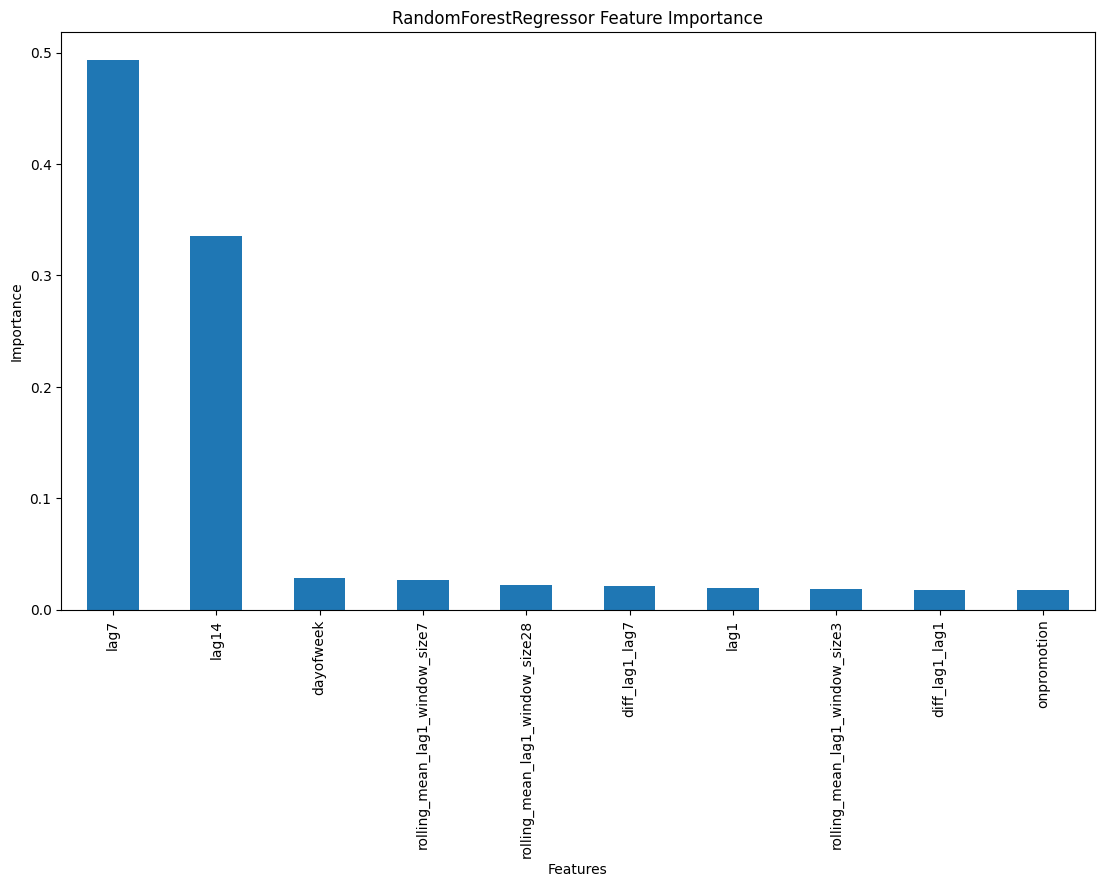

In [42]:
pd.Series(model.models_['RandomForestRegressor'].feature_importances_, index=model.ts.features_order_)\
  .sort_values(ascending=False).plot\
  .bar(figsize=(1280/96,720/96), title='RandomForestRegressor Feature Importance', xlabel='Features', ylabel='Importance')

#### How to measure forecast accuracy

We can compute the error using any metric we want, as we do when normally using scikit-learn.

I created a custom function to calculate WMAPE, which is an adaptation of the mean absolute percentage error that solves the problem of dividing by zero.

The weight of each sample is given by the magnitude of the real value.

Here’s the function for the simplified version of the metric:

In [43]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

print(f"WMAPE RandomForestRegressor: {wmape(p['y'], p['RandomForestRegressor'])}\nWMAPE ExtraTreesRegressor: {wmape(p['y'], p['ExtraTreesRegressor'])}")

WMAPE RandomForestRegressor: 0.18781740494466106
WMAPE ExtraTreesRegressor: 0.179807841911756


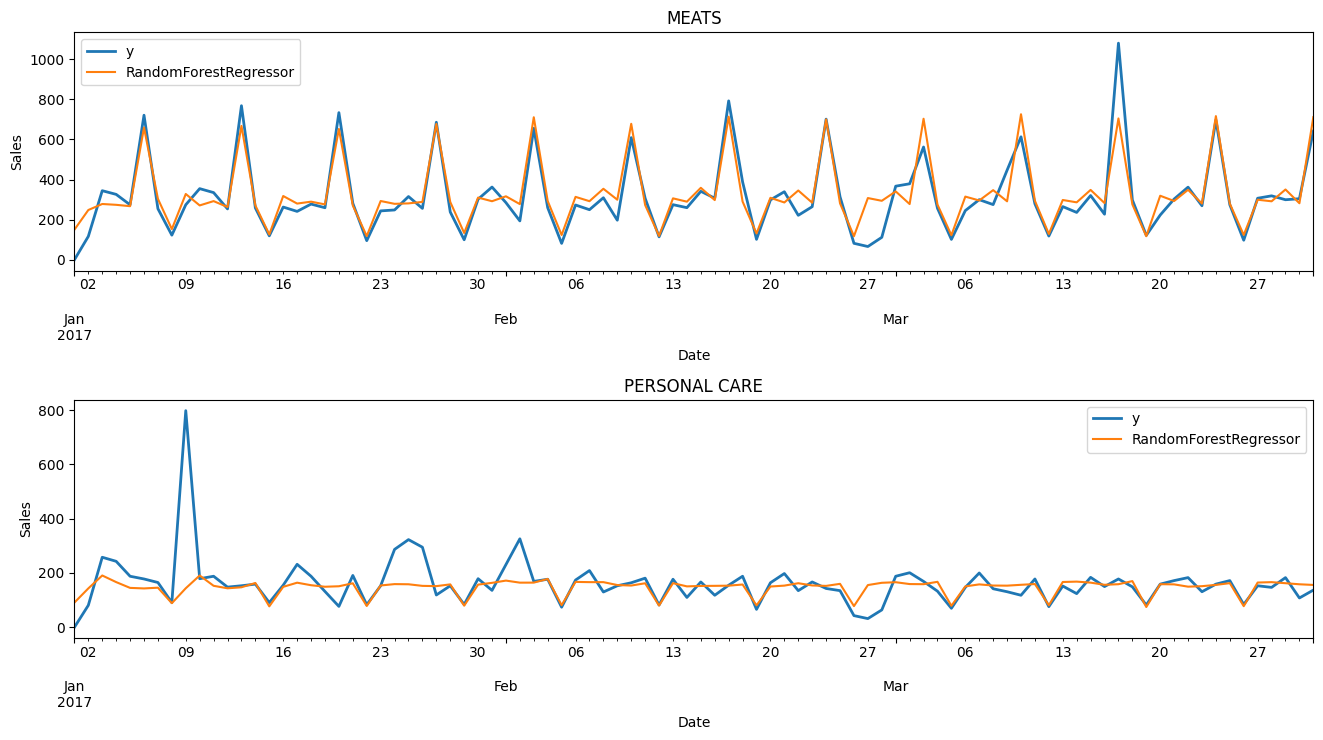

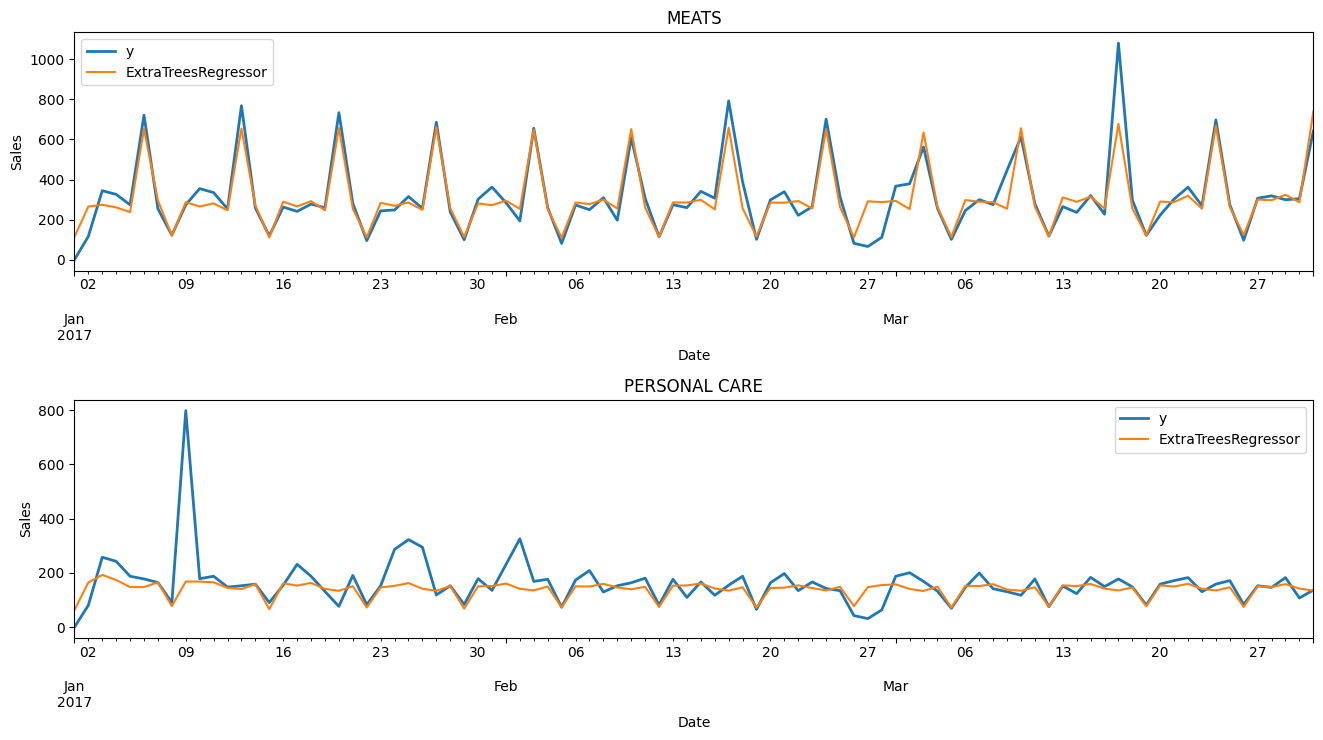

In [44]:
for model in ['RandomForestRegressor', 'ExtraTreesRegressor']:
    fig,ax = plt.subplots(2,1, figsize=(1280/96, 720/96))
    for ax_, family in enumerate(['MEATS', 'PERSONAL CARE']):
        p.loc[p['unique_id'] == family].plot(x='ds', y='y', ax=ax[ax_], label='y', title=family, linewidth=2)
        p.loc[p['unique_id'] == family].plot(x='ds', y=model, ax=ax[ax_], label=model)
        ax[ax_].set_xlabel('Date')
        ax[ax_].set_ylabel('Sales')
        fig.tight_layout()

### MLForecast - Multivariate Time Series Forecasting

Let’s use the Walmart Sales Forecasting dataset from Kaggle. This dataset contains the weekly sales, split by department, of 45 Walmart stores. What matters most to us here is that it has additional information like temperature, fuel price, CPI, unemployment rate, store size, etc.

We’ll use this information to train a multivariate time series model to predict the weekly sales of specific departments in specific stores.

Let’s start by loading the data:

In [48]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

path='data_wallmart'
data = pd.read_csv(os.path.join(path, 'train.csv'), 
                   parse_dates=['Date'])
features = pd.read_csv(os.path.join(path, 'features.csv'),
                       parse_dates=['Date'])
stores = pd.read_csv(os.path.join(path, 'stores.csv'))

**data** is the main dataset. It has the following columns:
- Store: the store number
- Dept: the department number
- Date: the date of the week
- Weekly_Sales: the sales for the given department in the given store at the given date
- IsHoliday: whether the week is a special holiday week

**features** contains additional variables with values for specific weeks. The columns are:
- Store: the store number
- Date: the week when the data was recorded
- Temperature: average temperature in the region
- Fuel_Price: cost of fuel in the region
- MarkDown1 to MarkDown5: anonymized data related to promotional markdowns
- CPI: the consumer price index
- Unemployment: the unemployment rate
- IsHoliday: whether the week is a special holiday week

We will remove the MarkDown columns, but use the rest of the features. 

The stores dataset contains information about the store’s characteristics. The columns are:
- Store: the store number
- Type: the type of store (A, B or C)
- Size: the size of the store
*Type is defined according to the size.*

We merge everything into a single dataset:

In [49]:
data = pd.merge(data, features, on=['Store', 'Date', 'IsHoliday'], how='left')
data = pd.merge(data, stores, on=['Store'], how='left')

# First, we set the date of each week to be the Sunday of that week.
data['Date'] = data['Date'].dt.to_period('W-SAT').dt.start_time


# I also removed the stores that didn’t have data for the whole period. 
# You can use everything I teach here with time series that have different sizes, but for simplicity I’ll not do it here.

last_date_by_store = data.groupby('Store')['Date'].last()
stores_with_full_data = last_date_by_store[last_date_by_store == data['Date'].max()].index
data = data.loc[data['Store'].isin(stores_with_full_data)]

# Let’s transform the categorical variables into one-hot encoded variables.
data['Type_A'] = (data['Type'] == 'A').astype(int)
data['Type_B'] = (data['Type'] == 'B').astype(int)
data['IsHoliday'] = data['IsHoliday'].astype(int)

# So I left Store and Dept as they are, but wanted to remind you of this option.

# Now I will create a unique_id column joining Store and Dept, 
# so that mlforecast knows they are different time series and can calculate the features accordingly.

data['unique_id'] = data['Store'].astype(str) + '_' + data['Dept'].astype(str)
data = data.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 
                  'MarkDown4', 'MarkDown5', 'Type'], axis=1)
data = data.rename(columns={'Weekly_Sales': 'y', 'Date': 'ds'})

# Finally, let’s split the data into train and validation sets. 
# We will use all data between 2010 and 2011 to train the model, and data from 2012 to validate it.

train = data.loc[data['ds'] < '2012-01-01']
valid = data.loc[data['ds'] >= '2012-01-01']
h = 4

#### Training A Multivariate Time Series Model In Python With MLForecast

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

from window_ops.rolling import rolling_mean, rolling_max, rolling_min

# The RandomForestRegressor is inside a scikit-learn pipeline, 
# so that we can use the SimpleImputer to fill any missing values in the data.
models = [make_pipeline(SimpleImputer(), 
                        RandomForestRegressor(random_state=0, n_estimators=100)),
          XGBRegressor(random_state=0, n_estimators=100)]


model = MLForecast(models=models,
                   freq='W',
                   lags=[1,2,4],
                   lag_transforms={
                       1: [(rolling_mean, 4), (rolling_min, 4), (rolling_max, 4)], # aplicado a uma janela W a partir do registro Lag
                   },
                   date_features=['week', 'month'],
                   num_threads=4)

The **MLForecast** object will manage the transformation of the data, the training of the models, and the prediction of the target variable. 
We pass the freq parameter to tell **mlforecast** that our data is weekly, and the lags parameter to tell it that we want to use the last 1, 2 and 4 weeks as features to predict the next week. 
We also pass the lag_transforms parameter, which is a dictionary that maps the number of lags to a list of functions to apply to the lagged values.
The keys are the lags over which we want to apply the functions, and the values are lists of tuples, where the first element is the function to apply, and the second element is the number of weeks to apply it to (the window).
So in this case, we will apply the rolling_mean, rolling_min and rolling_max functions to the last 4 weeks of each lag.

To be very clear, if today is week 5, the function will be applied to the values of week 1, 2, 3 and 4.

Before we train the model, let’s create two lists with the names of the dynamic and static features.

In [54]:
dynamic_features = ['IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
static_features = ['Type_A', 'Type_B', 'Size', 'Store', 'Dept']

- Dynamic features are the ones that change over time. You need to have these values for the future timestamps you want to predict.
- Static features are the ones that don’t change over time. MLForecast will repeat the first value of each static feature for all the timestamps you want to predict.

Be careful with dynamic features!

In this case, the IsHoliday column is easy to know in advance, but the Temperature, Fuel_Price, CPI and Unemployment columns are not.

We would need to use estimates for these values when this model is deployed. So, if you have this kind of feature, you can use the real historical values in your training set, but you should use estimates for the validation set and any future data. If you use historical values for the validation set and future data, you will get an overoptimistic out-of-sample accuracy and have a bad surprise when you deploy your model.

**As a rule of thumb, always ask the question: “Would I have this information if today was the last day of the training set? (the day you make the prediction)”.**

In [55]:
model.fit(train, id_col='unique_id', time_col='ds', target_col='y', static_features=static_features)

MLForecast(models=[Pipeline, XGBRegressor], freq=<Week: weekday=6>, lag_features=['lag1', 'lag2', 'lag4', 'rolling_mean_lag1_window_size4', 'rolling_min_lag1_window_size4', 'rolling_max_lag1_window_size4'], date_features=['week', 'month'], num_threads=4)

By default the forecast is generated in a recursive way, but we can also use the max_horizon parameter to generate the forecast with the direct method (one model for each step ahead)

In [56]:
model.fit(train, id_col='unique_id', time_col='ds', target_col='y', static_features=static_features, max_horizon=h)

MLForecast(models=[Pipeline, XGBRegressor], freq=<Week: weekday=6>, lag_features=['lag1', 'lag2', 'lag4', 'rolling_mean_lag1_window_size4', 'rolling_min_lag1_window_size4', 'rolling_max_lag1_window_size4'], date_features=['week', 'month'], num_threads=4)

In [57]:
p = model.predict(horizon=h, dynamic_dfs=[valid[['unique_id','ds']+dynamic_features]])
p = p.merge(valid[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')

/home/bruno/MachineLearning_Training/TimeSeries_Learning/time_series_analysis/lib/python3.8/site-packages/mlforecast/core.py:612: UserWarning: Found null values in lag2, lag4, rolling_mean_lag1_window_size4, rolling_min_lag1_window_size4, rolling_max_lag1_window_size4, IsHoliday, Temperature, Fuel_Price, CPI, Unemployment.
  warnings.warn(f'Found null values in {", ".join(nulls[nulls].index)}.')
/home/bruno/MachineLearning_Training/TimeSeries_Learning/time_series_analysis/lib/python3.8/site-packages/mlforecast/core.py:612: UserWarning: Found null values in lag2, lag4, rolling_mean_lag1_window_size4, rolling_min_lag1_window_size4, rolling_max_lag1_window_size4, IsHoliday, Temperature, Fuel_Price, CPI, Unemployment.
  warnings.warn(f'Found null values in {", ".join(nulls[nulls].index)}.')


We pass the horizon parameter to tell the model how many steps to predict after the end of the training data. Be careful with the dates here if you have errors about missing values in your data. 
This is why I had to set all the dates to the first Sunday of the week. The dates were not aligned between MLForecast and the validation data. 
We also pass the dynamic_dfs parameter, which is a list of dataframes with the dynamic features for the validation set.  We need columns to join the dataframes, so we pass the unique_id and ds in the dynamic features dataframe.

Finally, we merge the predictions with the validation data to calculate the error metrics. This is what p looks like at the end:

In [58]:
p

,unique_id,ds,Pipeline,XGBRegressor,y
0,10_1,2012-01-01,48989.6543,75332.460938,28520.49
1,10_1,2012-01-08,39299.0168,42848.187500,30107.31
2,10_1,2012-01-15,33212.3332,21515.785156,31180.23
3,10_1,2012-01-22,55701.0081,46619.238281,32559.13
4,10_10,2012-01-01,50423.5881,50885.722656,37105.46
...,...,...,...,...,...
2351,8_98,2012-01-22,7682.1423,5731.191406,5490.99
2352,8_99,2012-01-01,1148.8543,824.930237,NaN
2353,8_99,2012-01-08,1212.1482,1208.152710,NaN
2354,8_99,2012-01-15,1123.8694,1323.401978,NaN


To evaluate the model, I will use **SMAPE**, which helps us deal with zeros and negative values in the target variable.

Sometimes people use negative values in sales data to represent days when returns were higher than sales.

In [59]:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
   
print(f"SMAPE Random Forest Pipeline: {smape(p['y'], p['Pipeline'])}\nSMAPE XGBRegressor: {smape(p['y'], p['XGBRegressor'])}")

SMAPE Random Forest Pipeline: 20.937912132260205
SMAPE XGBRegressor: 22.523125732204637


The Random Forest model got a 20.94% SMAPE, and the XGBoost model got a 22.52%.

I purposefully plotted the time series with the best (32_95) and worst (35_59) performance.

For the worst series, it seems the model doesn’t understand that the first weeks of January are usually low, and it predicts a high value.

If you want to improve the forecasts, I would first investigate the data and understand if there are any shocks or anomalies that could be affecting the model.

Another idea is to tune the hyperparameters of models.

Take a look at the feature importances too.

This model is heavily dependent on the lag 1 feature, as you can see in the feature importance plot for XGBRegressor.

<AxesSubplot: title={'center': 'Feature Importance XGBRegressor'}>

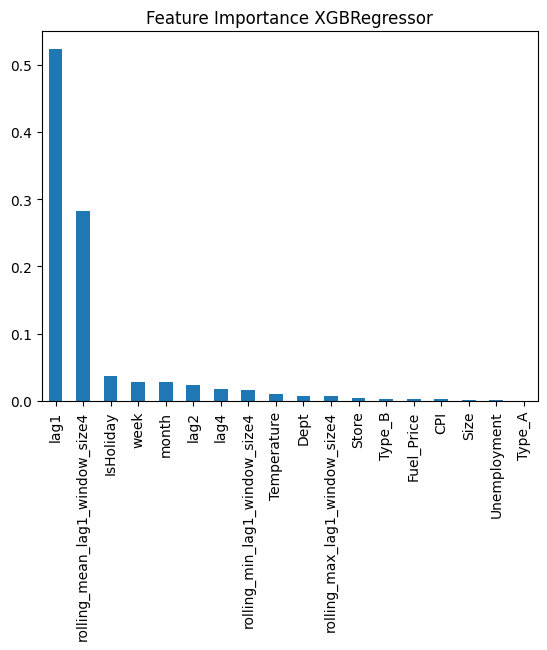

In [62]:
pd.Series(model.models_['XGBRegressor'][0].feature_importances_, index=model.ts.features_order_).sort_values(ascending=False).plot.bar(title='Feature Importance XGBRegressor')

After the first week, lag 1 is the prediction for the previous week, so the model will accumulate errors as it goes. If the errors are large, the model will get worse and worse.

This is a pattern specific of this data, not the models or methods.

If you have a similar problem, I would try removing the lag 1 features and modeling with max_horizon to see if the direct method would work better.

## NeuralForecast